# Recurrent Neural Networks

Recurrent Neural Networks(RNNs), sind neben CNNs, eine weitere spezielle Form eines Neural Networks. 
RNNs werden vor allem bei Sequenzen verwendet, die in festen Reihenfolgen angeordnet sind, und diese Reihenfolge auch die Interpretation der gesamten Sequenz beeinflusst. 

Sprachen als ein klassisches Beispiel drängt sich sofort auf. Denn der Inhalt eines Satzes hat Einfluss auf die Interpretation der einzelnen Wörter. 

Zum Beispiel:

> Ich bin kein Fan von diesem Film

Das Wort „*Fan*“ hat eine positive Konnotation. Doch das „*kein*“ vor dem Wort, dreht die Interpretation um. Das heißt, das Wort „*Fan*“ sollte im Kontext des gesamten Satzes interpretiert werden. 
Aber auch in der Chemie/Pharmazie können RNN Verwendung finden. Zum Beispiel Smiles Strings oder Protein Sequenzen eignen sich für RNNs. 

 `()` haben einen starken Einfluss darauf, wie einzelne Teile des Smiles interpretiert werden können.

`CCCC`|`CC(C)C`
------|--------
<img src="Img/rnn/mol1.png" width="200"/> |<img src="Img/rnn/mol2.png" width="200"/> 


Das generelle Konzept eines RNN ist relativ einfach:
Wort für Wort (oder auch Zeichen für Zeichen) wird ein Satz (Smiles) durch das Netzwerk geführt. 
Die Outputlayer wird zunächst komplett ignoriert, sondern nachdem ein Wort durch das Netzwerk geführt wird, werden die Activation der Hidden Layer ($h_1$) gespeichert.

Anhand des Beispielsatzes „*Hallo Welt*“ wird es im Bild erklärt. $h_1$ sind hier die Aktivations für das Wort „Hallo“.

Im Kontext von Recurrent Neural Networks, bezeichnen wir die Activations der Hidden Layer auch als **Hidden State**. $h_1$ ist der Hidden State für des Wort „*Hallo*“.

Als Nächstes wird das zweite Wort durch das Netzwerk geschickt. Wir wollen $h_2$ berechnen, doch zu den regulären Activation des Wortes „Welt“, addieren wir auch noch die Activations $h_1$ dazu. $h_2$ ist also eine Kombination aus den Activations von „Welt“, aber auch Hallo. Das heißt, das Wort „Welt“ wurde zusammen mit dem vorangehenden Wort interpretiert.

<img src="Img/rnn/rnn_1.svg.png" width="200"/> 

Hätten wir ein drittes Wort, würde sich $h_3$ aus den Activations des dritten Wortes und $h_2$ berechnen. Und da $h_2$ sowohl die Informationen vom zweiten als auch vom ersten Wort enthält, haben beide Worte Einfluss auf die Interpretation vom dritten Wort.


<img src="https://miro.medium.com/max/724/1*1U8H9EZiDqfylJU7Im23Ag.gif">
*Source: Michael Phi - An illustrated Guide to Recurrent Neural Networks*

Im GIF erkennen Sie, dass der Einfluss des Hidden States von „*What*“ (schwarz), das erste Wort, immer kleiner wird, je näher wir dem Satzende kommen. Es hat aber dennoch Einfluss auf die Interpretation des letzten Wortes.


Der Hidden State des letzten Teils des Satzes („*?* „), im Beispiel $O5$ ($h_5$) genannt, ist eine Kombination aus allen bisherigen Hidden States und den Activations von „*?* „.
<img src="https://ichi.pro/assets/images/max/724/1*yQzlE7JseW32VVU-xlOUvQ.png">

Diesen Hidden State können wir als Input für ein Netzwerk nutzen, dass anhand dieses letzten Hidden State seine Vorhersage macht.

Ähnlich wie ein CNN benutzt wird um ein Bild zu einem Vektor konvertiert, werden RNNs benutzt um Sequenzen zu Vektoren zu konvertieren.

# Datenaufbereitung:

Bevor wir aber unser RNN trainieren, müssen wir die Daten in das richtige Format bekommen. Buchstaben und Wörter können nämlich nicht einfach so von einem neuronalen Netzwerk gelesen werden.
Wie schon mit den Labels vom MNIST Datensatz (0-9), können wir Wörter, oder, im Falle von Smiles, Symbole „one-hot“ kodieren. 

Angenommen wir haben zwei Smiles:

`smiles = ["CCN=C=O","NC(=O)CC(=O)O"]`

Insgesamt gibt es 6 verschiedene Symbole:
`C`, `N`, `=`, `O`, `(`, `)` 

Wir können ein `C` als einen Vektor der Länge 6 darstellen. Dieser hat an der ersten Position eine `1` und sonst nur Nullen. Ein `N` können wir ebenfalls als Vektordarstellen, nur dass wir die `1` um eine Position verschieben.

Dies können wir für alle Symbole in den Smiles machen:

```python
"C" = [1,0,0,0,0,0]
"N" = [0,1,0,0,0,0]
"=" = [0,0,1,0,0,0]
"O" = [0,0,0,1,0,0]
"(" = [0,0,0,0,1,0]
")" = [0,0,0,0,0,1]
```
Diese Symbole werden auch oft **Tokens** genannt.
Wir können also einen Smiles String mithilfe dieser Regeln kodieren. Wir brauchen also pro Smiles eine Matrix:

```python
"CCN=C=O" -> np.array([[1,0,0,0,0,0],
                      [1,0,0,0,0,0],
                      [0,1,0,0,0,0],
                      [0,0,1,0,0,0],
                      [1,0,0,0,0,0],
                      [0,0,1,0,0,0],
                      [0,0,0,1,0,0]])
```

Aus dem String `"CCN=C=O"` wird eine Matrix in der jede Reihe ein Symbol ist und jede Spalte an gibt welches Symbole dieser Reihe zugeordnet ist.

Mit dem folgenden Code können Sie diese Transformation automatisieren.
Viele Funktionen sind vorgeschrieben. Wenn Sie aber dennoch Interesse haben, wie diese Funktionen genau aussehen, finden Sie den Code in `../utils/utils.py`.

In [1]:
import torch
from torch import nn, optim
from rdkit.Chem import AllChem as Chem
import numpy as np
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader, TensorDataset
%run ../utils/utils.py

In [2]:
smiles = ["CCN=C=O","NC(=O)CC(=O)O"]

Zunächst brauchen wir eine Art Wörterbuch, das alle vorkommenden Symbole speichert und ihnen eine Zahl zuordnet. Diese Zahl gibt auch an, an welche Position die `1` im one-hot Vektor sein wird. 

In [3]:
dictionary = create_dict(smiles)
dictionary

{'=': 0, 'N': 1, 'C': 2, 'O': 3, ')': 4, '(': 5}

Sie sehen, dem `=` wird eine `0` zugeordnet und dem `N` eine `1` usw...

Mit der Funktion `tokenize()` können Sie die Smiles in eine Zahlenreihe konvertieren. Wir repräsentieren den Smiles String nun, anhand der Zahlen die den Symbolen zugeordnet worden sind. 
Der Funktion muss nur gesagt werden, welche Smiles sie kodieren soll und welches „Wörterbuch“ es dafür verwenden soll.

In [4]:
tokenized_smiles = tokenize(smiles,dictionary)
tokenized_smiles

[[2, 2, 1, 0, 2, 0, 3], [1, 2, 5, 0, 3, 4, 2, 2, 5, 0, 3, 4, 3]]

Die Smiles werden jetzt schon mal als einfach Zahlenreihenfolge dargestellt.
Diese sind aber noch unterschiedlich lang.

In [5]:
[len(x) for x in tokenized_smiles]

[7, 13]

Ein Smiles besteht aus 7 Symbolen/Tokens, der andere aber aus 13. Das ist ein Problem, denn ein RNN erwartet, dass jeder Sequenz gleich lang ist. Das ist natürlich unrealistisch, denn größere Moleküle haben mehr Symbole als kleinere. 
Um das Problem zu lösen, *„padden“* wir alle Sequenzen auf die Länge des längsten Smiles.
Das „*padden *“ bedeutet, wir fügen ein neues Symbol unserem Dictionary hinzu: `"<pad>"`. Dieses Symbol wird an jeden Smiles string hinzugefügt, bis er dieselbe Länge hat wie der längste Smiles. Das `"<pad>"` soll dem Netzwerk „sagen“, dass diese Symbole nicht mehr relevant für den Smiles sind.

In [6]:
max_smiles_length = max([len(x) for x in tokenized_smiles])
max_smiles_length

13

In [7]:
dictionary["<pad>"] = len(dictionary)
dictionary

{'=': 0, 'N': 1, 'C': 2, 'O': 3, ')': 4, '(': 5, '<pad>': 6}

Nun haben wir den `pad` Token unserem Wörterbuch hinzugefügt. Als Letztes müssen wir nur noch unserem ersten Smiles `tokenized_smiles[0]` diesen Token anhängen.

In [8]:
num_fehlende_tokens = max_smiles_length-len(tokenized_smiles[0])
tokenized_smiles[0] += [dictionary["<pad>"]] * num_fehlende_tokens 
tokenized_smiles[0]

[2, 2, 1, 0, 2, 0, 3, 6, 6, 6, 6, 6, 6]

Jetzt sind beide Smiles gleich lang:

In [9]:
[len(x) for x in tokenized_smiles]

[13, 13]

Jetzt können wir auch die Smiles zu one-hot Vektoren konvertieren.
Dafür brauchen wir die Anzahl verschiedenen Symbole:

In [10]:
vocabulary_length = len(dictionary)
print(vocabulary_length)

7


Insgesamt befinden sich 7 Symbole in unserem Wörterbuch.
Mit der Funktion `token_to_onehot` werden aus den `tokenized_smiles` one-hot Matrizen.

In [11]:
onehot_tokens = token_to_onehot(tokenized_smiles, vocabulary_length)
print(onehot_tokens, onehot_tokens.shape)

[[[0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 1.]]

 [[0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0.]
  [1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0.]
  [1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0.]]] (2, 13, 7)


`onehot_tokens` ist ein `numpy` Array mit den Dimensionen `2,13,7`. Die erste Dimension sind die Anzahl der Smiles Strings (`2`). Die zweite Dimension ist die Länge der Sequenzen (`13`). Die dritte Dimension gibt die Anzahl der verschiedene Token an (`7`).

An sich wären unseren Daten jetzt bereit für ein RNN. Doch anstatt diese one-hot kodierten Vektoren als Input zu nehmen benutzen wir zuvor noch eine *Word Embedding Layer*. 

# Word Embedding

Tatsächlich werden diese one-hot kodierten Vektoren nicht mehr direkt als Input benutzt. Bevor sie in das Netzwerk geführt werden, wird noch eine Embedding Layer benutzt. Diese ersetzt die one-hot kodierten Vektoren mit zunächst zufälligen Zahlen. Um besser zu verstehen, was gemeint ist, schauen wir uns zunächst eine Embedding Layer an.

In [12]:
np.random.seed(1234)
embedding_layer=np.random.rand(7,4)
embedding_layer

array([[0.19151945, 0.62210877, 0.43772774, 0.78535858],
       [0.77997581, 0.27259261, 0.27646426, 0.80187218],
       [0.95813935, 0.87593263, 0.35781727, 0.50099513],
       [0.68346294, 0.71270203, 0.37025075, 0.56119619],
       [0.50308317, 0.01376845, 0.77282662, 0.88264119],
       [0.36488598, 0.61539618, 0.07538124, 0.36882401],
       [0.9331401 , 0.65137814, 0.39720258, 0.78873014]])

Eine Embedding Layer besteht aus einer einzigen Weight Matrix. Diesen enthält zufällige Zahlen. Die Anzahl der Reihen entspricht exakt der Anzahl der verschiedenen Tokens in unserem Wörterbuch. 
Eine Embedding Layer tauscht, dementsprechend den Vektor `[1,0,0,0,0,0,0]` mit der ersten Reihe aus der `embedding_layer[0,:]= [0.19151945, 0.62210877, 0.43772774, 0.78535858]` aus.

Um das zu erreichen, müssen wir einfach die one-hot kodierten Smiles mit der Embedding Layer multiplizieren:

In [13]:
token_embeddings = np.matmul(onehot_tokens,embedding_layer)
print(token_embeddings[0])

[[0.95813935 0.87593263 0.35781727 0.50099513]
 [0.95813935 0.87593263 0.35781727 0.50099513]
 [0.77997581 0.27259261 0.27646426 0.80187218]
 [0.19151945 0.62210877 0.43772774 0.78535858]
 [0.95813935 0.87593263 0.35781727 0.50099513]
 [0.19151945 0.62210877 0.43772774 0.78535858]
 [0.68346294 0.71270203 0.37025075 0.56119619]
 [0.9331401  0.65137814 0.39720258 0.78873014]
 [0.9331401  0.65137814 0.39720258 0.78873014]
 [0.9331401  0.65137814 0.39720258 0.78873014]
 [0.9331401  0.65137814 0.39720258 0.78873014]
 [0.9331401  0.65137814 0.39720258 0.78873014]
 [0.9331401  0.65137814 0.39720258 0.78873014]]


Sie sehen hier drüber die Embeddings des ersten Smiles.
Hier drunter ist die erste Reihe des one-hot kodierten Smiles.

In [14]:
onehot_tokens[0,0,:]

array([0., 0., 1., 0., 0., 0., 0.])

Dieser hat an der 3 Position (index `2`) eine `1`.
Wenn Sie sich jetzt in der Weight Matrix der `embedding_layer` die dritte Reihe (index `2`) anschauen, fällt auf, dass dieser Vektor genau dieselben Werte hat, wie die erste Reihe in der `token_embeddings` Layer.

In [15]:
embedding_layer[2,:]

array([0.95813935, 0.87593263, 0.35781727, 0.50099513])

In [16]:
token_embeddings[0,0,:]

array([0.95813935, 0.87593263, 0.35781727, 0.50099513])

Einfacher erklärt: 
Eine Embedding Layer konvertiert one-hot kodierte Vektoren zu Vektoren mit zufälligen Gewichten. 

*Aber warum wird das gemacht?*

Ein Vorteil ist, dass in den meisten Fällen Texte oder auch Smiles aus mehr als nur 7 Symbolen oder Wörtern bestehen. Würden wir zum Beispiel alle Wörter, die in einem Dokument vorkommen, kodieren, würden diese Vektoren sehr lang werden. Durch das „embedden“ der Vektoren, können wir zunächst die Größe dieser Inputvektoren reduzieren.

Wichtiger ist aber, dass die Weights in der Embedding Layer gelernt werden können. Das heißt diese Weights werden bei der Backpropagation mit upgedatet.
Damit passen sich die Embeddings während des Trainings an. Das ist praktisch, denn man erwartet, dass durch das Training ähnliche Wörter ähnlich Embddings erhalten. Zum Beispiel, die Wörter LKW und Auto sind im Sprachgebrauch ähnlicher als Auto und Strand. 
Wenn Auto und LKW ähnliche Embeddings haben, also durch ähnliche Vektoren beschrieben werden, dann hat können diese auch leichter im Kontext des Satzes verarbeitet werden.


> Ein Auto fährt auf der Straße

> Ein LKW fährt auf der Straße

Beschreiben zwei sehr ähnlich Situation und wenn auch die numerischen Repräsentationen sich ähneln, fällt es dem Netzwerk leichter diese zu lernen.

Im Falle von Smiles kann man argumentieren, dass die Rolle von Stickstoff in einem Molekül ähnlicher zu einen Kohlenstoff ist, als zu einem Fluor. Dies sollte sich vor allem in den Embeddings widerspiegeln.


# RNNs

Wir haben nun die Smiles in das richtige Format konvertiert. Wir müssen nur noch das `numpy` array zu einem Tensor konvertieren. Achten Sie darauf, dass wir auch die Funktion `.permute` benutzen. `.permute` wird verwendet, um Dimensionen von einem Tensor zu vertauschen. Denn für RNNs erwartetet PyTorch, dass die Tensor wie folgt angeordnet sind:

`[Länge des Smiles, Anzahl der Smiles, Embeddinggröße]`

In [17]:
token_embeddings_tensor = torch.tensor(token_embeddings, dtype= torch.float).permute(1,0,2)
token_embeddings_tensor.shape

torch.Size([13, 2, 4])

Der Tensor `token_embeddings_tensor` hat die oben gelisteten Dimensionen. Jeder Smiles besteht aus `13` Token, unser Batch besteht aus `2` Smiles und jeder Token wird mit `4` Werten beschrieben. 

Wir können nun ein RNN definieren. Wie auch sonst gibt es ein RNN auch im `torch.nn` Modul.
Auch hier müssen Sie beim Definieren der Dimensionen aufpassen. Die erste Dimension ist die Größe des Inputs, also die Embeddingsgröße (`4`). Die zweite Dimension gibt an wie viele Nodes wir in der Hidden Layer haben wollen. Dieser gibt auch an, wie groß die Vektoren des Hidden States werden sollen.

In [18]:
torch.manual_seed(1234)
rnn = nn.RNN(4,10)

Sie können jetzt einfach `token_embeddings_tensor` durch das `rnn` führen.

In [19]:
output_rnn = rnn(token_embeddings_tensor)
len(output_rnn)

2

Der Output des RNN (`output_rnn`) ist eine Liste mit der Länge zwei.
Wir schauen uns zunächst das erste Objekt des Outputs an.

In [20]:
print(output_rnn[0])

tensor([[[-0.6540,  0.1824,  0.1200,  0.4636, -0.0831, -0.2290,  0.3849,
           0.3114,  0.4953,  0.1924],
         [-0.6074,  0.1729,  0.1613,  0.3752, -0.0612, -0.1318,  0.2538,
           0.3650,  0.5437,  0.0800]],

        [[-0.6201,  0.0397,  0.0467,  0.5561, -0.1582, -0.1902,  0.0533,
           0.2024,  0.5232,  0.0419],
         [-0.6291,  0.0600,  0.0284,  0.5624, -0.2045, -0.1845,  0.0926,
           0.2466,  0.5708,  0.0416]],

        [[-0.5073,  0.0867, -0.0092,  0.5796, -0.1643, -0.1114, -0.1150,
           0.2933,  0.6187, -0.1547],
         [-0.3727,  0.2763, -0.1432,  0.5627, -0.0995, -0.1747, -0.1914,
           0.1635,  0.5000, -0.1977]],

        [[-0.4378,  0.2924, -0.1356,  0.6046, -0.1448, -0.1848, -0.2003,
           0.1723,  0.5326, -0.2877],
         [-0.5051,  0.3958, -0.0952,  0.6255, -0.1017, -0.1391, -0.1083,
           0.1592,  0.5074, -0.2954]],

        [[-0.6462,  0.2525, -0.0672,  0.7318, -0.2121, -0.1398,  0.1564,
           0.2445,  0.5865, -0.

In [21]:
print(output_rnn[0].shape)

torch.Size([13, 2, 10])


Der `output_rnn[0]` hat die Dimensionen `[13, 2, 10]`. Das einzige, was sich, im Vergleich zum Input, verändert hat, ist die letzte Dimension. Anstatt der Größe `4` ist diese jetzt `10`. 

Der erste Teil des RNN enthält nämlich die Hidden States von jedem Symbol im Smiles.

Wenn Sie an das GIF zurückdenken:
<img src="https://miro.medium.com/max/724/1*1U8H9EZiDqfylJU7Im23Ag.gif">
*Source: Michael Phi - An illustrated Guide to Recurrent Neural Networks*

`output_rnn[0]` enthält $O1$ bis $O5$. Bloß da unsere Sequenzen die Länge 13 haben, enthält `output_rnn[0]` eben 13 Hidden States.

Doch was enthält `output_rnn[1]`

In [22]:
output_rnn[1]

tensor([[[-0.5935,  0.0763, -0.0591,  0.7040, -0.1913, -0.1583,  0.0249,
           0.2617,  0.5862, -0.1860],
         [-0.5304,  0.1756, -0.0967,  0.6344, -0.2509, -0.1894, -0.0759,
           0.2257,  0.6100, -0.1583]]], grad_fn=<StackBackward0>)

In [23]:
output_rnn[1].shape

torch.Size([1, 2, 10])

`output_rnn[1]` enthält NUR den letzten Hidden State. Im GIF ist das $O5$, bei uns wäre es $O13$. Dieser Hidden State beschreibt (theoretisch) die komplette Sequenz, und ist deswegen besonders wichtig.

Sie können es auch kontrollieren:

In [24]:
print(output_rnn[0][-1])
output_rnn[1]

tensor([[-0.5935,  0.0763, -0.0591,  0.7040, -0.1913, -0.1583,  0.0249,  0.2617,
          0.5862, -0.1860],
        [-0.5304,  0.1756, -0.0967,  0.6344, -0.2509, -0.1894, -0.0759,  0.2257,
          0.6100, -0.1583]], grad_fn=<SelectBackward0>)


tensor([[[-0.5935,  0.0763, -0.0591,  0.7040, -0.1913, -0.1583,  0.0249,
           0.2617,  0.5862, -0.1860],
         [-0.5304,  0.1756, -0.0967,  0.6344, -0.2509, -0.1894, -0.0759,
           0.2257,  0.6100, -0.1583]]], grad_fn=<StackBackward0>)


Um genauer zu verstehen, was passiert, werden wir das PyTorch RNN selber nochmal programmieren.


Angenommen wir haben einen Satz `satz = ["Hello", "World"]`. Diesen haben wir als zwei Wörter in einer Liste gespeichert. 

Wir definieren auch zwei einfache Linear Layers.  Die eine mappt den Input von `4` Buchstaben auf `10` Dimensionen. Die andere Layer mappt von `10` auf `10`.

Durch das erste Netzwerk schicken wir das erste Wort `satz[0]` und speichern den Hidden State in `output_1`

```python
satz = ["Hello", "World"]

lin_1 = nn.Linear(4,10) 

lin_2 = nn.Linear(10,10)

output_1 =rnn(satz[0])
```
Als Nächstes führen wir auch das zweite Wort „World“ durch das `lin_1`. Doch im Anschluss addieren wir auch den `lin_2(output_1)` dazu. 

```python
satz = ["Hello", "World"]

lin_1 = nn.Linear(4,10) 

lin_2 = nn.Linear(10,10)

output_1 = lin_1(satz[0])

output_2 = lin_1(satz[1]) + lin_2(output_1)
```

Das heißt, der Hidden State `output_2` wird nicht alleine durch das Wort „`World`“ bestimmt, sondern der Hidden State zuvor hat auch Einfluss. Tatsächlich fügen wir auch noch eine nicht-lineare Aktivierungsfunktion hinzu. In RNNs wird per Default eine Tanh-Funktion anstatt einer ReLU-Funktion benutzt.

```python
satz = ["Hello", "World"]

lin_1 = nn.Linear(4,10) 

lin_2 = nn.Linear(10,10)

output_1 = lin_1(satz[0])

output_2 = torch.tanh(lin_1(satz[1]) + lin_2(output_1))
```

Hätten wir noch ein drittes Wort im Satz (`satz[2]`), dann würde sich der Schritt wiederholen. Wir addieren diesmal, aber nicht `output_1`, sondern `output_2` hinzu:

```python
satz = ["Hello", "World"]

lin_1 = nn.Linear(4,10) 

lin_2 = nn.Linear(10,10)

output_1 = lin_1(satz[0])

output_2 = torch.tanh(lin_1(satz[2]) + lin_2(output_1))
```


Um dies zu kontrollieren, schreiben wir dafür ein eigenes Programm.
Zunächst speichern wir die Weights des `rnn`. Diese können wir nun selber benutzen.
Denken Sie daran, dass `nn.Linear()` nicht anderes macht als: `torch.mm(X,W.t())+b`

In [25]:
w_1=list(rnn.parameters())[0]
w_2=list(rnn.parameters())[1]
b_1=list(rnn.parameters())[2]
b_2=list(rnn.parameters())[3]

Mit diesen Weights können Sie nun den Hidden State für das erste Symbol in der Smiles Sequenz berechnen (`lin_1`). Diese befinden sich in `token_embeddings_tensor[0]`.

In [26]:
activations_jetzt = torch.mm(token_embeddings_tensor[0],____)+____
activations_jetzt

NameError: name '____' is not defined

<details>
    <summary><b>Lösung:</b></summary>

```python
activations_jetzt = torch.mm(token_embeddings_tensor[0],w_1.t())+b_1
activations_jetzt
```
</details>

Als Nächstes transformieren wir noch den Hidden State des vorherigen Tokens (`lin_2`). 
Allerdings sind wir doch momentan beim erstem Wort/Token. Wir haben also noch keinen Hidden State von einem vorherigen Token. Dieser Teil wurde im Text vorher unterschlagen. Tatsächlich fangen wir mit einem Hidden State an, bei dem alle Werte Null sind. `h0 = torch.zeros(2,10)`

In [485]:
h0 = torch.zeros(2,10)

activations_vorher = torch.mm(___,____)+____

NameError: name '____' is not defined

<details>
    <summary><b>Lösung:</b></summary>

```python
h0 = torch.zeros(2,10)

activations_vorher = torch.mm(h0,w_2.t())+b_2
```
</details>

Im letzten Schritt werden die beiden Activations addiert und eine `torch.tanh` Aktivierungsfunktion angewandt.

In [408]:
torch.tanh(___________+_____________)

tensor([[-0.6540,  0.1824,  0.1200,  0.4636, -0.0831, -0.2290,  0.3849,  0.3114,
          0.4953,  0.1924],
        [-0.6074,  0.1729,  0.1613,  0.3752, -0.0612, -0.1318,  0.2538,  0.3650,
          0.5437,  0.0800]], grad_fn=<TanhBackward>)

<details>
    <summary><b>Lösung:</b></summary>

```python
torch.tanh(activations_jetzt+activations_vorher)
```
</details>

Das ist der Hidden State für den ersten Token/erstes Symbol vom Smiles.
Wir können die Richtigkeit auch mit dem von `nn.RNN` berechneten Hidden States vergleichen und sehen, dass diese identisch sind.

In [30]:
output_rnn[0][0]

tensor([[-0.6540,  0.1824,  0.1200,  0.4636, -0.0831, -0.2290,  0.3849,  0.3114,
          0.4953,  0.1924],
        [-0.6074,  0.1729,  0.1613,  0.3752, -0.0612, -0.1318,  0.2538,  0.3650,
          0.5437,  0.0800]], grad_fn=<SelectBackward0>)

Wir wollen die Hidden States nicht nur für den ersten Token berechnen, sondern für alle Token im Smiles. Deswegen brauche wir einen for-loop. 

Wir initialisieren zunächst wieder den ersten Hidden State mit Nullen. Und schreiben dann einen for_loop der durch alle 13 Tokens iteriert.

In [410]:
h0 = torch.zeros(2,10)
for i in range(max_smiles_length):
    activations_jetzt =  # achten Sie bei der Berechnung darauf immer das i Element aus den Input auszuwählen
    activations_vorher = 
    h0 = torch.tanh(activations_jetzt+activations_vorher) # <-- Der output wird als h0 gespeichert, 
h0                                                        #     um ihn in der nächsten Iteration als neues h0
                                                          #     zuverwenden              

tensor([[-0.5935,  0.0763, -0.0591,  0.7040, -0.1913, -0.1583,  0.0249,  0.2617,
          0.5862, -0.1860],
        [-0.5304,  0.1756, -0.0967,  0.6344, -0.2509, -0.1894, -0.0759,  0.2257,
          0.6100, -0.1583]], grad_fn=<TanhBackward>)

`h0` enthält jetzt den finalen Hidden State. Auch hier können wir wieder kontrollieren, ob unser Ergebnis mit dem vom PyTorch `rnn` übereinstimmt.

<details>
    <summary><b>Lösung:</b></summary>

```python
h0 = torch.zeros(2,10)
for i in range(max_smiles_length):
    activations_jetzt = torch.mm(token_embeddings_tensor[i],w_1.t())+b_1
    activations_vorher = torch.mm(h0,w_2.t())+b_2
    h0 = torch.tanh(activations_jetzt+activations_vorher) 
h0                                                     
```                                                          
</details>

In [32]:
output_rnn[1]

tensor([[[-0.5935,  0.0763, -0.0591,  0.7040, -0.1913, -0.1583,  0.0249,
           0.2617,  0.5862, -0.1860],
         [-0.5304,  0.1756, -0.0967,  0.6344, -0.2509, -0.1894, -0.0759,
           0.2257,  0.6100, -0.1583]]], grad_fn=<StackBackward0>)

Natürlich ist einfacher PyTorchs vorgeschriebene Funktion zu benutzen. 
Aber das Selbstprogrammieren sollte Ihnen beim Verständnis helfen. 

Darüber hinaus veranschaulicht der Code, die größte Schwäche von RNNs: der `for-loop`.
Wir können einen Satz/Smiles nicht auf einmal durch das Netzwerk führen. 
Sondern jedes Wort/Symbol, muss einzeln hintereinander durch das 
Netzwerk geführt werden. Das macht RNNs extrem langsam.

# PyTorch RNN

PyTorch
 stellt uns nicht nur RNNs zur Verfügung, sondern auch `nn.Embedding` 
Layers. Das ist praktisch. Zum einen erleichtert uns das die 
Backpropagation. Zum anderen müssen wir dadurch auch nicht erst die 
one-hot kodierten Vektoren berechnen. PyTorch nimmt sofort als Input die
 durch Token ersetzten Smiles. `tokenized_smiles`

In [33]:
tokenized_smiles

[[2, 2, 1, 0, 2, 0, 3, 6, 6, 6, 6, 6, 6],
 [1, 2, 5, 0, 3, 4, 2, 2, 5, 0, 3, 4, 3]]

In [34]:
emb = nn.Embedding(7,4, padding_idx = dictionary["<pad>"])

Oben wurde eine `torch` Embedding Layer definiert. Sie nimmt als Input die Anzahl der unterschiedlichen Symbole/Tokens in unserem Datensatz. Bei uns wären das `7`. Der zweite Parameter gibt die Größe der Embeddingvektoren an. Wir bleiben bei der Größe `4`. Als Letztes können wir PyTorch mitteilen welcher Token, also welcher Zahl für das Padding steht. PyTorch setzt darauf hin die Embeddings für diese Token auf null.

In [35]:
emb(torch.tensor(tokenized_smiles)).shape

torch.Size([2, 13, 4])

Der Output dieser Embedding Layer ist noch nicht im richtige Format. Wir müssen noch die Dimensionen des Tensors mithilfe von `Permute` ändern. 
Wir können all diese Schritte, wie auch zuvor in ein `nn.Sequential()` Modul packen. 

*Im Pytorch `nn` Modul gibt es kein Permute, diese wurde von uns angepasst damit sie auch in `nn.Sequential` funktioniert. Deswegen brauchen wir auch kein "nn." vor dem Permute.*

In [36]:
model =nn.Sequential(nn.Embedding(7,4, padding_idx = dictionary["<pad>"]),
                     Permute(1,0,2),
                     nn.RNN(4,10))

model

Sequential(
  (0): Embedding(7, 4, padding_idx=6)
  (1): Permute()
  (2): RNN(4, 10)
)

Die `tokenized_smiles` können jetzt durch das `model` geführt werden. `[1][0,:,:]` wird benutzt, um die finalen Hidden States im richtigen Format zu extrahieren. Diese können wir direkt in eine Linear Layer führen. Da wir den Output mit `[1][0,:,:]` indizieren müssen, können wir die Linear Layers nicht direkt im selben `nn.Sequential()` Model benutzten. Sondern wir brauchen in zweites Model, dass den `output_rnn` als Input nimmt.

In [37]:
output_rnn= model(torch.tensor(tokenized_smiles))[1][0,:,:]

In [38]:
pred_ll = nn.Sequential(nn.Linear(10,1))

In [39]:
pred_ll(output_rnn)

tensor([[0.1583],
        [0.0377]], grad_fn=<AddmmBackward0>)

Ein Problem gibt es noch mit dem `nn.RNN`. Im GIF ist klar zuerkennen, dass je länger der Satz wird, desto weniger Einfluss haben die ersten Wörter im Satz.  Das kann gerade ein Problem werden, wenn Sätze oder Smiles besonders lang werden. Gerade wenn Nebensätze, oder im Fall von Smiles extra Ringe, in den String eingeschoben werden, kann es passieren, dass der Anfang des Satzes oder Smiles vom Netzwerk vergessen wurde.

Deswegen werden in der Regel komplexere RNN Layers benutzt. Diese erlaubt es Netzwerken, über längere String, Informationen zu erhalten.

Eine beliebte Alternative ist die "Gated Recurrent Unit" (GRU). Das Kombinieren von Hidden States ist um einiges komplexer als bei vanilla RNNs, aber in PyTorch können `nn.RNN` einfach mit `nn.GRU` ausgetauscht werden, ohne dass irgendetwas anderes geändert werden muss.

RNN   |GRU
------|--------
<img src="https://miro.medium.com/max/332/0*eRJCRsikdGGu8ffA.png" width="200"/> |<img src="https://miro.medium.com/max/700/1*RiOzdOVaaeKrUotY7-1a2A.png" width="300"/> 


# Übungsaufgabe:

In der Übungsaufgabe werden wir uns mit einem neuen Datensatz befassen. Der Blood-Brain Barrier Penetration (BBBP) Datensatz erfasst für 2000 Moleküle, ob sie durch die Blut-Hirn-Schranke diffundieren können.

Die meisten Medikamente und Neurotransmitter können die Blut-Hirnschranke nicht überwinden. Doch gerade dies ist wichtig für Medikamente, die im Zentralen Nerven System wirken sollen. Deswegen ist von präzise Vorhersage dieser Eigenschaften vom großen Interesse.
Der originale Datensatz wurde 2012 veröffentlicht. Wir verwenden aber einen leicht veränderten Datensatz. Hierbei wurden alle Informationen zu Stereochemie aus den Smiles entfernt. Auch enthält der Datensatz nur SMILES die aus weniger als 75 Symbolen bestehen.

> Martins, Ines Filipa, et al. “A Bayesian approach to in silico blood-brain barrier penetration modeling.” Journal of Chemical Information and Modeling 52.6 (2012): 1686-1697.



In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from rdkit.Chem import AllChem as Chem
import numpy as np
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
%run ../utils/utils.py

Sie könnnen zunächste den Datensatz einlesen.

In [41]:
data_bbbp = pd.read_csv("../data/bbbp/bbbp_clean.csv")
data_bbbp.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/bbbp/bbbp_clean.csv'

Die `smiles` sind zusammen mit dem `target` angeben. Eine `1` bedeutet, dass diese Moleküle durch die BBB diffundieren kann. In der folgenden Zelle berechnen wir den Prozentsatz der Moleküle, die diese Eigenschaft besitzen, in dem Datensatz besitzen.

In [1031]:
np.sum(data_bbbp.target)/data_bbbp.shape[0]*100

78.88548057259713

Wegen des großen Ungleichgewichtes bietet sich als Metrik vor allem der ROC-AUC an.
Doch bevor wir uns dem Training zuwenden können, müssen wir erst die Daten aufbereiten.
Erstellen Sie zunächst einen `dictionary`, der allen Symbolen im Smiles Zahlen zuordnet.

In [1033]:
dictionary = create_dict(data_bbbp.smiles)

In [834]:
dictionary

{'N': 0,
 '(': 1,
 '2': 2,
 'c': 3,
 'O': 4,
 ')': 5,
 '1': 6,
 'C': 7,
 '=': 8,
 'Cl': 9,
 '3': 10,
 'n': 11,
 'F': 12,
 'o': 13,
 '-': 14,
 'S': 15,
 'H': 16,
 ']': 17,
 '[': 18,
 '4': 19,
 's': 20,
 'Br': 21,
 '#': 22,
 'I': 23,
 '+': 24,
 '5': 25,
 'P': 26,
 '6': 27,
 'B': 28}

Mit diesem Dictionary, konvertieren Sie nun die eigentlichen Symbole der Smiles zu zahlen.

In [1034]:
tokenized_smiles = tokenize(data_bbbp.smiles,dictionary)

Das Problem ist, wie auch schon im Beispiel, dass die Moleküle und damit die Smiles unterschiedlich lang sind:

In [1035]:
length_ll = np.array([len(x) for x in tokenized_smiles])
length_ll

array([27, 36, 48, ..., 43, 56, 49])

Sie müssen deswegen erst alle `tokenized_smiles` auf die gleiche Länge bringen. Und zwar auf die des längsten Smiles. 

In [1036]:
max_length = max(length_ll)
max_length

74

Allen Smiles, die aus weniger als 74 Tokens bestehen, fügen wir so lange extra Tokens hinzu, bis sie 74 Tokens lang sind.
Der Token, der beigefügt wird, ist `<pad>`. Wir ordnen ihm den Wert `len(dictionary)` zu, da dieser die nächste ungenutzte Zahl ist.

In [1038]:
print(len(dictionary))
dictionary["<pad>"]= len(dictionary)

29


Der folgende Code hängt diesen Paddingtoken an alle Smiles.

In [1041]:
for i, tok_smi in enumerate(tokenized_smiles):
    tokenized_smiles[i] = tok_smi+ [dictionary["<pad>"]]*(max_length - length_ll[i])

In [1042]:
length_ll = [len(x) for x in tokenized_smiles]
length_ll

[74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,
 74,


Nun sind alle `tokenized_smiles` gleich lang und im richtigen Format. Sie müssen aber zuvor wieder die Daten in Trainings- und Testdatensatz teilen. 
Davor fügen wir zuvor die `tokenized_smiles` und Targets aus dem `data_bbbp` zusammen. 

In [1044]:
data_bbbp_tokenized = np.hstack([np.array(tokenized_smiles), data_bbbp.iloc[:,1:2]])
data_bbbp_tokenized

array([[ 7.,  7.,  1., ..., 29., 29.,  1.],
       [ 7.,  7.,  1., ..., 29., 29.,  1.],
       [ 7.,  7.,  6., ..., 29., 29.,  1.],
       ...,
       [ 7.,  7.,  1., ..., 29., 29.,  1.],
       [ 7.,  7.,  3., ..., 29., 29.,  1.],
       [18.,  0., 14., ..., 29., 29.,  1.]])

In [892]:
train, test=train_test_split(data_bbbp_tokenized,test_size=0.2,train_size=0.8, random_state=1234)

Nun separieren Sie die Input und Outputs wieder von einander. Wichtig hierbei: Die targets befinden sich in der letzen Spalte.

In [ ]:
train_x = torch.tensor(train[:,:-1], dtype=torch.long )
train_y = torch.tensor(train[:,-1], dtype=torch.float)
test_x = torch.tensor(test[:,:-1], dtype=torch.long)
test_y = torch.tensor(test[:,-1], dtype=torch.float)

Erstellen Sie jetzt den Trainings Dataloader, damit wir mit Minibatches trainieren können. 

In [893]:
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=32)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=32)

Jetzt definieren Sie das Model.
Wir brauchen eine Embedding Layer, eine Permute Layer und ein RNN. Hierfür verwenden wir ein GRU.

In [1075]:
torch.manual_seed(1111)
model =nn.Sequential(nn.Embedding(len(dictionary),32, padding_idx = dictionary["<pad>"]),
                     Permute(1,0,2),
                     nn.GRU(32,64))


Auch brauchen Sie eine Linear Layer, die eine anhand des Outputs des GRU eine Prediction macht. 
Dafür erstellen wir ein zweites Model Names `pred_ll`.

Warum brauchen wir ein zweites Model?

Das liegt daran, dass alle RNNs in PyTorch mehr als einen Output haben. Einmal alle Hidden States und einmal die finalen Hidden States. Das `nn.Sequential` Netzwerk, weiß in diesem Fall nicht welchen Output es vom RNN weiter in die Linear Layer führen soll.

Darum brauchen wir ein zweites Model `pred_ll`. Hier benutzen wir Batchnorm, und Dropout. Achten Sie dabei darauf, dass die Dimensionen von `BatchNorm1d` und `Linear`, der Outputdimension des `GRU` entsprechen.

In [1076]:
torch.manual_seed(1111)
pred_ll = nn.Sequential(nn.BatchNorm1d(64),nn.Dropout(0.2),nn.Linear(64,1))

Auch definieren Sie wieder eine Lossfunktion und einen Optimizer. Denken Sie daran, dass wir eine Binary Klassifikation haben.
Da wir zwei Netzwerke haben, die wir zusammen updaten wollen, können wir die Parameter, der beiden Netzwerke, in einer List kombinieren und dem Optimizer zur Verfügung stellen.

In [1077]:
loss_funktion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(list(model.parameters()) + list(pred_ll.parameters()), lr =0.001) 

In [1078]:
for i in range(40):
    pred_ll.train()
    for input_, targets in train_loader:
        optimizer.zero_grad()
        rnn_output = model(input_)[1][0]
        output = pred_ll(rnn_output).flatten()
        
        loss = loss_funktion(output, targets)
        loss.backward()
        optimizer.step()
    
    pred_ll.eval()
    
    rnn_output = model(train_x)[1][0]    
    output = pred_ll(rnn_output).flatten()
    loss_train = loss_funktion(output, train_y)
    auc_train = roc_auc_score(train_y.numpy(),torch.sigmoid(output).detach().clone().numpy())
    
    rnn_output = model(test_x)[1][0]    
    output = pred_ll(rnn_output).flatten()
    loss_test = loss_funktion(output, test_y)
    auc_test = roc_auc_score(test_y.numpy(),torch.sigmoid(output).detach().clone().numpy())
    
    print("Training Loss: %.3f Training AUC: %.3f | Test Loss: %.3f Test AUC: %.3f"
        % (loss_train.item(), auc_train,loss_test.item(), auc_test ))


Training Loss: 0.657 Training AUC: 0.706 | Test Loss: 0.663 Test AUC: 0.665
Training Loss: 0.670 Training AUC: 0.732 | Test Loss: 0.699 Test AUC: 0.720
Training Loss: 0.851 Training AUC: 0.735 | Test Loss: 0.859 Test AUC: 0.719
Training Loss: 0.560 Training AUC: 0.746 | Test Loss: 0.606 Test AUC: 0.733
Training Loss: 0.687 Training AUC: 0.770 | Test Loss: 0.740 Test AUC: 0.745
Training Loss: 0.466 Training AUC: 0.782 | Test Loss: 0.537 Test AUC: 0.732
Training Loss: 0.679 Training AUC: 0.778 | Test Loss: 0.734 Test AUC: 0.692
Training Loss: 0.508 Training AUC: 0.791 | Test Loss: 0.649 Test AUC: 0.716
Training Loss: 0.403 Training AUC: 0.807 | Test Loss: 0.537 Test AUC: 0.708
Training Loss: 0.666 Training AUC: 0.817 | Test Loss: 0.749 Test AUC: 0.700
Training Loss: 0.431 Training AUC: 0.828 | Test Loss: 0.551 Test AUC: 0.707
Training Loss: 0.406 Training AUC: 0.847 | Test Loss: 0.537 Test AUC: 0.723
Training Loss: 0.485 Training AUC: 0.865 | Test Loss: 0.589 Test AUC: 0.743
Training Los

Sie sehen auch, mit einem RNN können Sie genaue Vorhersagen machen. In der Realität, funktionieren aber gerade bei kleinen Datensätzen ECFP und klassischen neuronale Netzwerke besser, da diese nicht so komplex sind. 
Als Letztes schauen wir uns noch die erlernten Embeddings an. 
Dafür speichern wir die Weight Matrix der Embedding Layer.

In [1096]:
embedding_weights = list(model[0].parameters())[0].detach().clone().numpy()
embedding_weights.round(2)

array([[-0.1 ,  0.15,  0.16,  0.52,  0.11, -0.66,  0.41, -1.08, -0.06,
        -2.17, -1.12, -2.25,  0.19, -1.83, -0.78,  0.77,  1.77,  1.97,
         0.08, -0.27, -0.54, -0.62, -0.59, -0.18, -1.64,  1.33,  2.32,
        -0.64, -0.19, -0.38,  1.32, -1.01],
       [ 0.2 , -0.97,  1.19,  0.46, -0.55,  2.33, -0.18,  0.38, -0.18,
         0.01, -0.09,  1.23, -0.18, -0.07, -1.49, -0.77,  0.34,  0.3 ,
        -0.69, -0.76, -0.43,  2.85, -0.7 ,  1.21,  0.15,  0.28, -0.88,
        -0.69, -1.21,  1.14,  0.73, -0.45],
       [ 1.47,  0.87,  0.17, -0.94, -0.62,  1.41,  0.28,  0.55,  0.58,
        -0.03, -0.56, -1.36, -0.55, -0.42,  1.27, -0.56, -0.72, -1.86,
        -0.1 ,  1.46,  0.29,  0.01,  0.43, -0.25,  0.95, -2.44, -0.43,
        -0.1 ,  0.69, -1.47, -1.45, -0.3 ],
       [-0.71, -0.15, -0.47,  0.12, -1.03,  0.19, -0.91, -1.52,  0.37,
         0.28, -2.  ,  0.21, -0.28,  0.17, -0.96,  0.46,  1.57, -0.67,
        -0.56, -0.04,  0.4 , -1.72, -0.84, -0.02, -0.32,  1.48,  0.84,
        -0.94, -

Eine Möglichkeit die Embeddings zu analysieren, ist die Ähnlichkeit verschiedener Token über die `cosine_similarity` vergleichen. Tokens mit ähnlicher Funktion sollten ähnlicher Embeddings erhalten.

Als Beispiel berechnen wir die Ähnlichkeit der Embeddings von einem Stickstoff in einem aromatischen Ring (`n`).
Dafür finden wir im Dictionary welche Zahl zu `"n"` gehört, und damit auch den Index der Reihe in der Embedding Matrix.


In [1105]:
idx_n = dictionary["n"]
dictionary["n"]

11

Wir berechnen die Similarity von dieser Embedding zu allen andere Embeddings. Im Anschluß wird ein Barchart erstellt.

In [1108]:
similarity_N = cosine_similarity(embedding_weights[idx_n:idx_n+1,:],embedding_weights)[0]
labels = [x for x in dictionary]

<AxesSubplot:xlabel='symbol'>

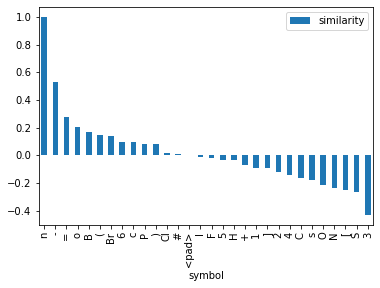

In [1109]:
sorted_values=pd.DataFrame({"symbol": labels, "similarity":similarity_N}).sort_values("similarity", ascending =False)
sorted_values.plot.bar("symbol", "similarity")

Das Problem bei einem so kleinen Datensatz ist, dass die Embeddings extrem stark vom Datensatz abhängig sind. Trotzdem können generelle Trends erkannt werden. `n` ist ähnlicher zu aromatischen Atomen `o` oder `c` als zu Atomen außerhalb eines aromatischen Rings `C`, `N` und `O`. Die genauen Embeddings können aber auch extrem von Training zu Training variieren.

Sie können auch andere Symbole vergleichen, indem Sie hier:

`idx_n = dictionary["n"]`

Ein anderes Symbol auswählen.